# P2. Classification on the Walmart Dataset

Task: load the Walmart dataset, write a Support Vector Machine to perform classification over the Month or Season (S1:JAN-FEB-MAR, S2:APR,MAY,JUN, S3:JUL,AUG,SEP, S4:OCT,NOV,DEC) in which a purchase was made, test the network and plot the results for each class.
<!-- ![Walmart](https://raw.githubusercontent.com/Masterx-AI/Project_Retail_Analysis_with_Walmart/main/Wallmart1.jpg) -->


## Task 0: Import libraries ✅

In [1]:
!pip install numpy matplotlib pandas seaborn scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set_theme()
%matplotlib inline

## Task 1: Download/Import Dataset 📃

Link: https://www.kaggle.com/datasets/yasserh/walmart-dataset/input

In [3]:
import os
# Make sure to upload the data in colab
# Importing our dataset
df = pd.read_csv("Walmart.csv")
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Task 2: Exploring the data 📃

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

## Task 3: Preparing the Data 📃
Normalization of the data

In [6]:
from sklearn.model_selection import train_test_split
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = (df['Month']-1) // 3 + 1

df_final = df
df_final = pd.get_dummies(df_final, columns=['Store'], drop_first=True)
df_final = pd.get_dummies(df_final, columns=['Year'], drop_first=True)
df_final = df_final.drop(columns=['Date', 'Season', 'Month', ]) #'Year'


df_train, df_test, months_train, months_test, seasons_train, seasons_test = train_test_split(df_final, df['Month'], df['Season'], test_size=0.25, random_state=42)

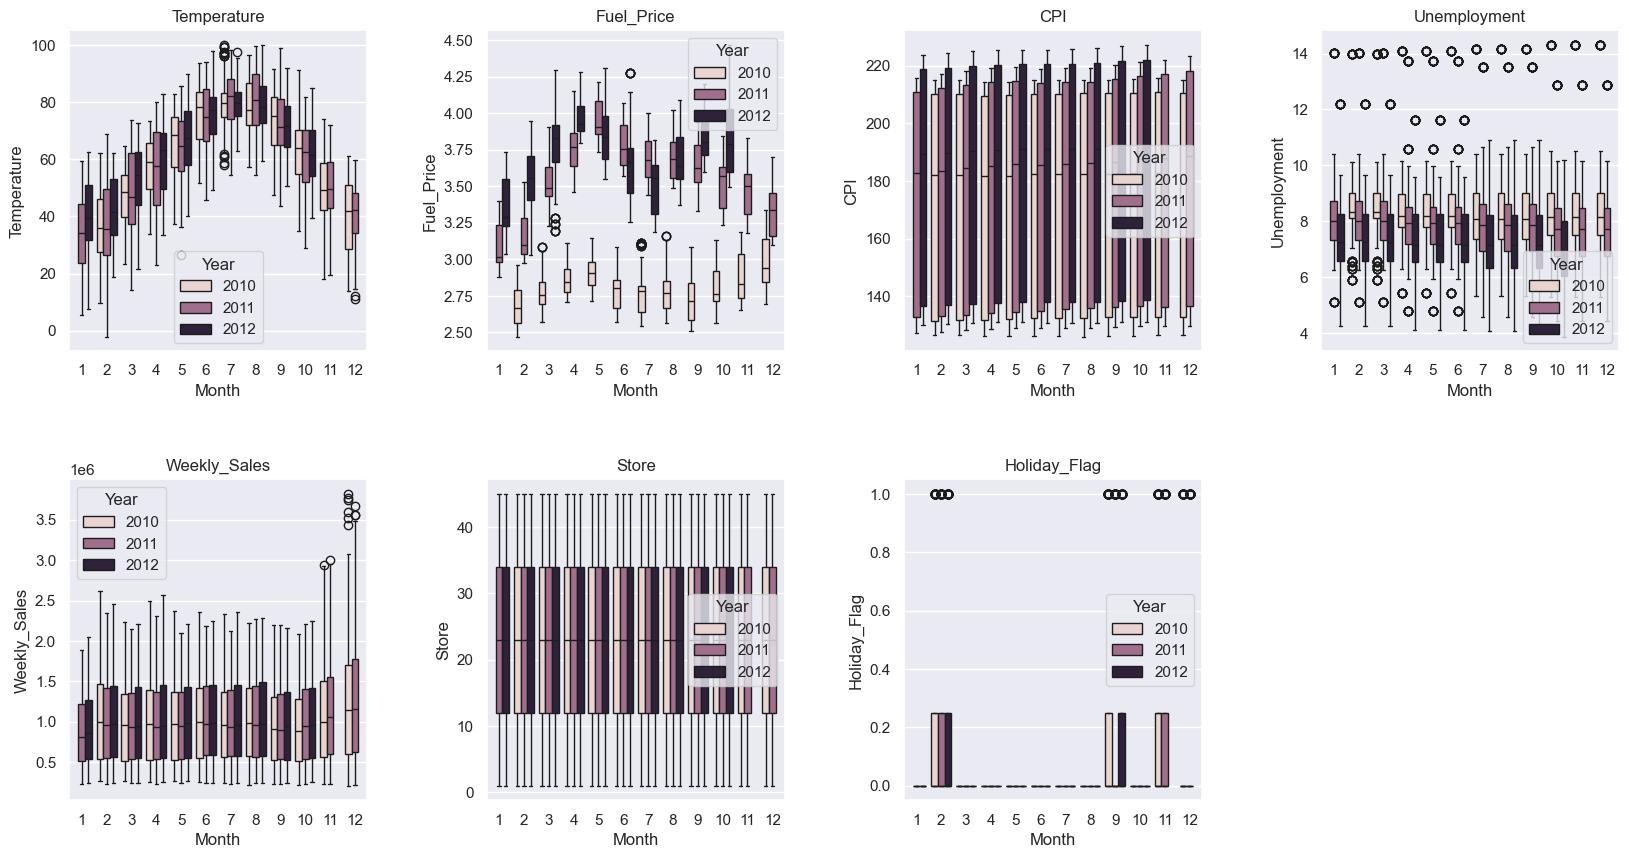

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Store', 'Holiday_Flag']):
  sns.boxplot(x='Month', y=column, hue='Year', data=df, ax=axs[i])
  axs[i].set_title(f'{column}')
  axs[i].set_xlabel('Month')
  axs[i].set_ylabel(column)

fig.delaxes(axs[-1])
plt.show()

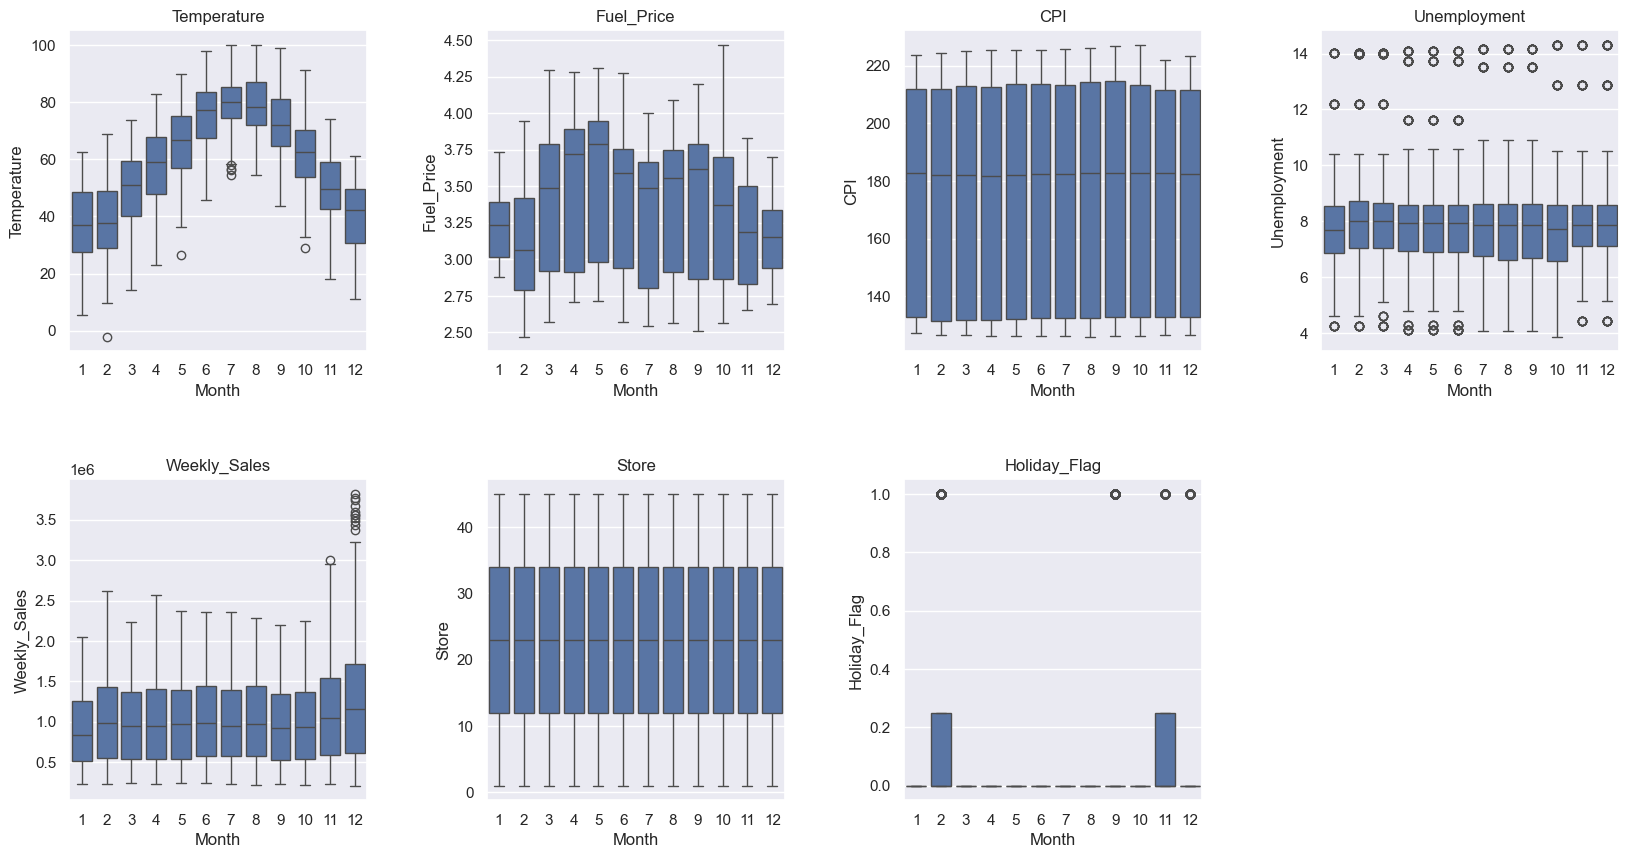

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekly_Sales', 'Store', 'Holiday_Flag']):
  sns.boxplot(x='Month', y=column, data=df, ax=axs[i])
  axs[i].set_title(f'{column}')
  axs[i].set_xlabel('Month')
  axs[i].set_ylabel(column)

fig.delaxes(axs[-1])
plt.show()

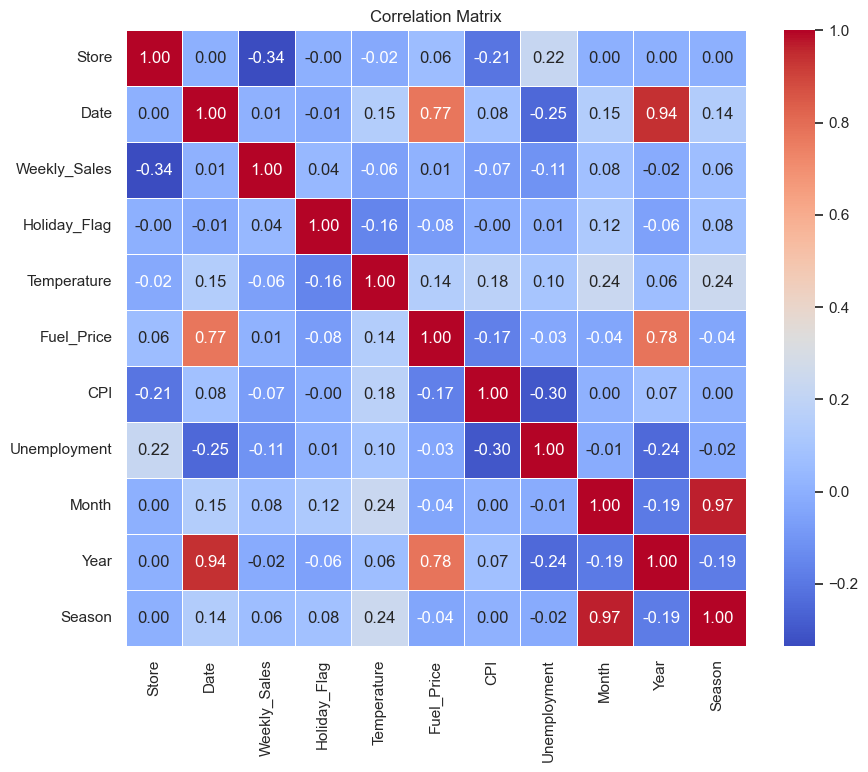

In [9]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [10]:
random_indices = np.random.choice(df_train.index, size=5, replace=False)
print(df_train.loc[random_indices])
print(months_train.loc[random_indices])
print(seasons_train.loc[random_indices])

      Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price         CPI  \
4097     504601.29             0        50.62       3.571  136.466667   
6319     722262.21             0        78.44       2.805  182.622635   
4423    1379783.21             0        77.72       3.620  221.808352   
3345    1346994.53             0        31.36       3.605  133.614143   
833     1517075.67             0        72.66       3.688  223.334621   

      Unemployment  Store_2  Store_3  Store_4  Store_5  ...  Store_38  \
4097         9.357    False    False    False    False  ...     False   
6319         8.743    False    False    False    False  ...     False   
4423         6.565    False    False    False    False  ...     False   
3345         8.252    False    False    False    False  ...     False   
833          5.964    False    False    False    False  ...     False   

      Store_39  Store_40  Store_41  Store_42  Store_43  Store_44  Store_45  \
4097     False     False     False     False

## Task 3: Define the SVM 📃

In [11]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
  StandardScaler(),
  SVC(kernel='rbf', class_weight='balanced')
)
param_grid = {'svc__C': [0.1, 1, 100, 1000, 100000],
              'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
grid = GridSearchCV(pipeline, param_grid, refit = True, verbose = 3)

## Task 4: Train 📃

In [12]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.447 total time=   0.9s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.520 total time=   0.8s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.487 total time=   0.8s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.504 total time=   0.8s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.513 total time=   0.8s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.370 total time=   0.8s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.396 total time=   0.8s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.406 total time=   0.8s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.410 total time=   0.8s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.417 total time=   0.8s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.539 total time=   0.8s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

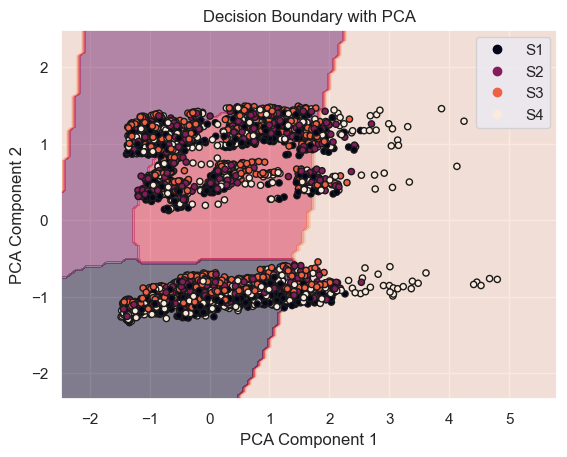

In [13]:
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Fit the model with PCA for 2 components to visualize the decision boundary
pca = PCA(n_components=2, whiten=True, svd_solver='randomized', random_state=42)
df_train_pca = pca.fit_transform(df_train)
df_test_pca = pca.transform(df_test)

svc = SVC(kernel='rbf', class_weight='balanced', C=grid.best_params_['svc__C'], gamma=grid.best_params_['svc__gamma'])
svc.fit(df_train_pca, seasons_train)

# Plot decision boundary
DecisionBoundaryDisplay.from_estimator(svc, df_train_pca, response_method="predict", alpha=0.5)
scatter = plt.scatter(df_train_pca[:, 0], df_train_pca[:, 1], c=seasons_train, edgecolor='k', s=20)
plt.title('Decision Boundary with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['S1', 'S2', 'S3', 'S4'])
plt.show()

## Task 6: Show results and compare different values of C 📃

              precision    recall  f1-score   support

           1       0.91      0.95      0.93       354
           2       0.93      0.84      0.88       446
           3       0.86      0.94      0.90       454
           4       0.94      0.90      0.92       355

    accuracy                           0.91      1609
   macro avg       0.91      0.91      0.91      1609
weighted avg       0.91      0.91      0.91      1609



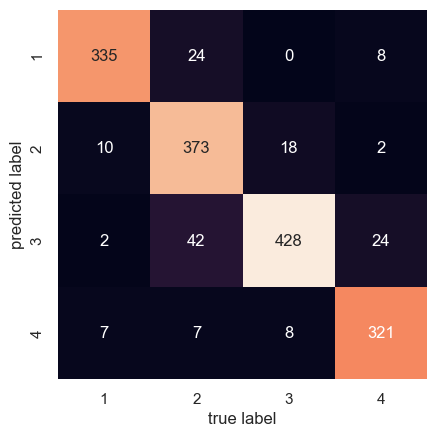

In [14]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Train for the months

In [15]:
grid.fit(df_train, months_train)
model = grid.best_estimator_
print(grid.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.088 total time=   1.0s
[CV 2/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   1.0s
[CV 3/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.055 total time=   1.0s
[CV 4/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.084 total time=   1.0s
[CV 5/5] END ..........svc__C=0.1, svc__gamma=1;, score=0.097 total time=   1.0s
[CV 1/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.089 total time=   1.0s
[CV 2/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.055 total time=   1.0s
[CV 3/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.055 total time=   1.0s
[CV 4/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.084 total time=   1.0s
[CV 5/5] END ........svc__C=0.1, svc__gamma=0.1;, score=0.097 total time=   1.0s
[CV 1/5] END .......svc__C=0.1, svc__gamma=0.01;, score=0.173 total time=   1.0s
[CV 2/5] END .......svc__C=0.1, svc__gamma=0.01

              precision    recall  f1-score   support

           1       0.92      0.91      0.92        89
           2       0.83      0.90      0.86       130
           3       0.69      0.76      0.72       135
           4       0.68      0.65      0.67       154
           5       0.63      0.68      0.65       133
           6       0.62      0.60      0.61       159
           7       0.59      0.69      0.64       162
           8       0.62      0.59      0.60       147
           9       0.75      0.73      0.74       145
          10       0.80      0.67      0.73       148
          11       0.63      0.61      0.62        97
          12       0.81      0.78      0.80       110

    accuracy                           0.70      1609
   macro avg       0.72      0.71      0.71      1609
weighted avg       0.71      0.70      0.70      1609



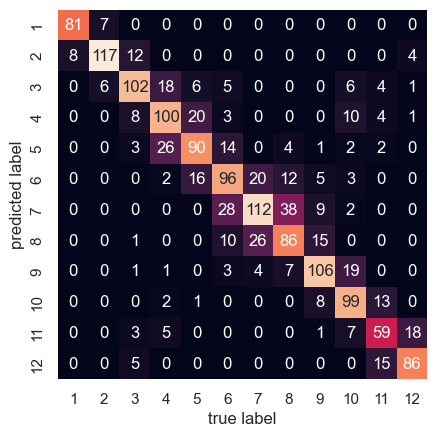

In [16]:
from sklearn.metrics import confusion_matrix
df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))

### Try adding PCA to the model and see if it improves the results

In [17]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [18]:
grid.fit(df_train, seasons_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.255 total time=   0.4s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.267 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.277 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.272 total time=   0.4s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.274 total time=   0.4s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.256 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.262 total time=   0.4s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.295 total time=   0.4s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.270 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.261 total time=   0.4s
[CV 1/5

              precision    recall  f1-score   support

           1       0.82      0.92      0.87       354
           2       0.87      0.75      0.81       446
           3       0.85      0.93      0.89       454
           4       0.87      0.81      0.84       355

    accuracy                           0.85      1609
   macro avg       0.85      0.85      0.85      1609
weighted avg       0.85      0.85      0.85      1609



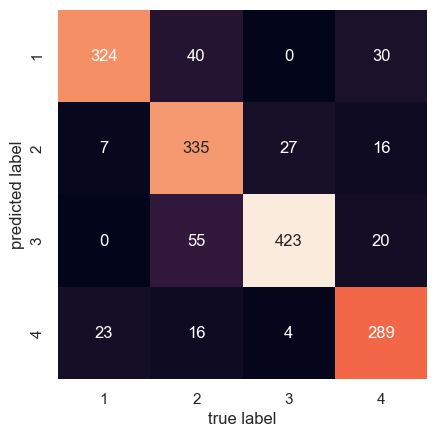

In [19]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(seasons_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(seasons_test),
            yticklabels=np.unique(seasons_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(seasons_test, df_fit))

### Train also the months

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'pca__n_components': [1, 2, 3, 4, 5, 6, 7]}
grid = GridSearchCV(model, param_grid, refit = True, verbose = 3)

In [21]:
grid.fit(df_train, months_train)
model = grid.best_estimator_

# Print the best parameters
print(grid.best_params_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.073 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.074 total time=   0.5s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.077 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.084 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=1;, score=0.088 total time=   0.5s
[CV 1/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.072 total time=   0.5s
[CV 2/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.070 total time=   0.5s
[CV 3/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.079 total time=   0.5s
[CV 4/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.078 total time=   0.5s
[CV 5/5] END pca__n_components=1, svc__C=0.1, svc__gamma=0.1;, score=0.081 total time=   0.5s
[CV 1/5

              precision    recall  f1-score   support

           1       0.78      0.78      0.78        89
           2       0.59      0.72      0.65       130
           3       0.55      0.60      0.57       135
           4       0.63      0.50      0.56       154
           5       0.59      0.62      0.60       133
           6       0.68      0.63      0.65       159
           7       0.57      0.60      0.58       162
           8       0.50      0.52      0.51       147
           9       0.65      0.68      0.67       145
          10       0.72      0.64      0.68       148
          11       0.58      0.60      0.59        97
          12       0.73      0.65      0.69       110

    accuracy                           0.62      1609
   macro avg       0.63      0.63      0.63      1609
weighted avg       0.62      0.62      0.62      1609



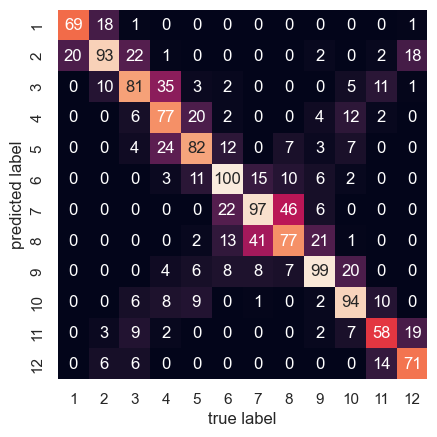

In [22]:
from sklearn.metrics import confusion_matrix

df_fit = model.predict(df_test)
mat = confusion_matrix(months_test, df_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(months_test),
            yticklabels=np.unique(months_test))
plt.xlabel('true label')
plt.ylabel('predicted label')

from sklearn.metrics import classification_report
print(classification_report(months_test, df_fit))